# Digit Recognition from Scratch
NumPy-only neural network (784 → 128 → 10) trained on MNIST


In [11]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import urllib.request
import gzip
import os
import pickle

np.random.seed(42)


In [12]:
# download and load MNIST dataset
def download_mnist():
    mirrors = [
        "https://github.com/fgnt/mnist/raw/master/",
        "http://yann.lecun.com/exdb/mnist/",
        "https://ossci-datasets.s3.amazonaws.com/mnist/",
    ]
    files = [
        "train-images-idx3-ubyte.gz",
        "train-labels-idx1-ubyte.gz",
        "t10k-images-idx3-ubyte.gz",
        "t10k-labels-idx1-ubyte.gz"
    ]
    os.makedirs("mnist_data", exist_ok=True)
    for filename in files:
        filepath = os.path.join("mnist_data", filename)
        if os.path.exists(filepath):
            print(f"exists: {filename}")
            continue
        for url in mirrors:
            try:
                urllib.request.urlretrieve(url + filename, filepath)
                print(f"downloaded: {filename}")
                break
            except:
                continue
        else:
            raise Exception(f"failed to download {filename}")

def load_images(path):
    with gzip.open(path, 'rb') as f:
        f.read(4)
        n = int.from_bytes(f.read(4), 'big')
        r = int.from_bytes(f.read(4), 'big')
        c = int.from_bytes(f.read(4), 'big')
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(n, r, c)

def load_labels(path):
    with gzip.open(path, 'rb') as f:
        f.read(8)
        return np.frombuffer(f.read(), dtype=np.uint8)

def preprocess(images, labels):
    X = images.reshape(images.shape[0], -1).astype(np.float32) / 255.0
    Y = np.zeros((labels.shape[0], 10))
    Y[np.arange(labels.shape[0]), labels] = 1
    return X, Y

download_mnist()

train_images = load_images("mnist_data/train-images-idx3-ubyte.gz")
train_labels = load_labels("mnist_data/train-labels-idx1-ubyte.gz")
test_images  = load_images("mnist_data/t10k-images-idx3-ubyte.gz")
test_labels  = load_labels("mnist_data/t10k-labels-idx1-ubyte.gz")

X_train, Y_train = preprocess(train_images, train_labels)
X_test,  Y_test  = preprocess(test_images,  test_labels)

print(f"train: {X_train.shape}, test: {X_test.shape}")


exists: train-images-idx3-ubyte.gz
exists: train-labels-idx1-ubyte.gz
exists: t10k-images-idx3-ubyte.gz
exists: t10k-labels-idx1-ubyte.gz
train: (60000, 784), test: (10000, 784)


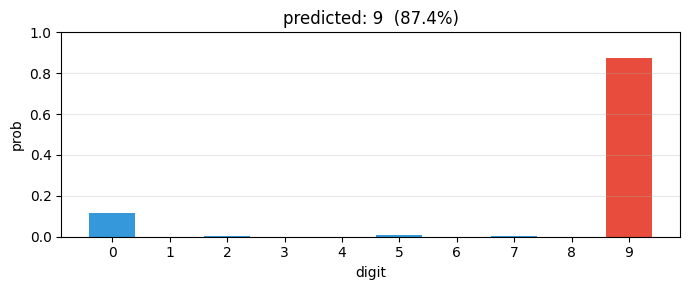

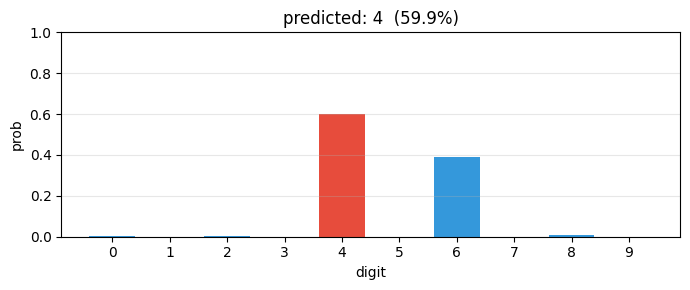

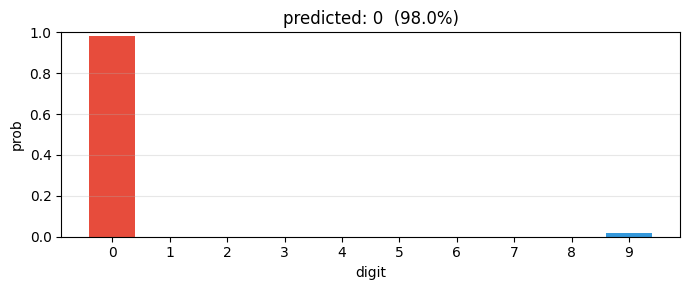

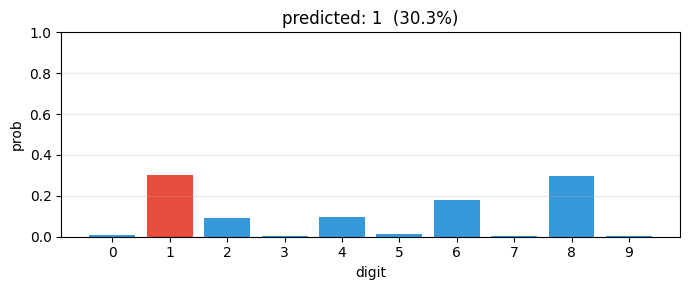

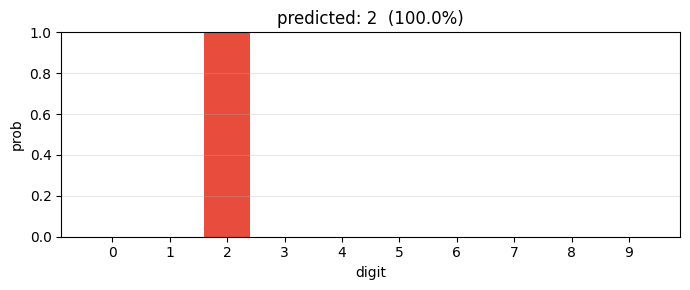

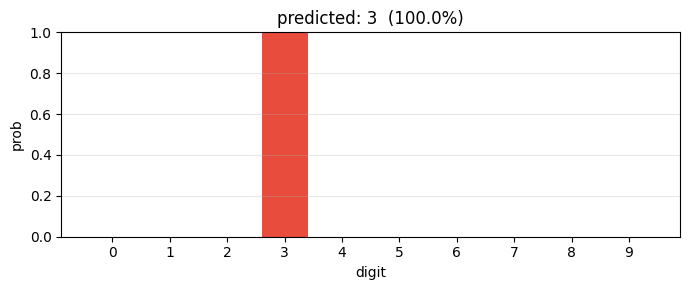

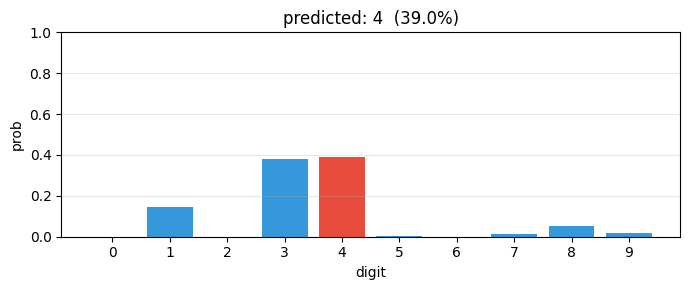

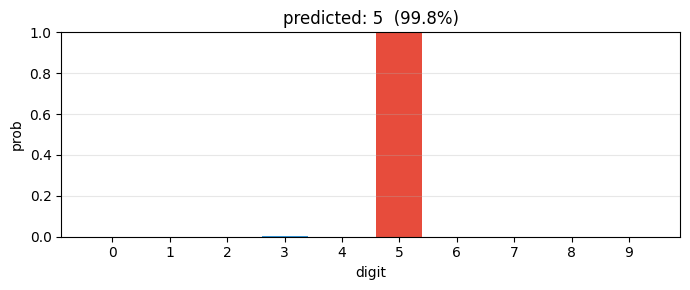

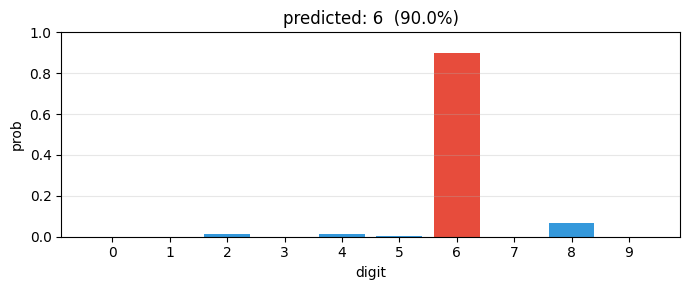

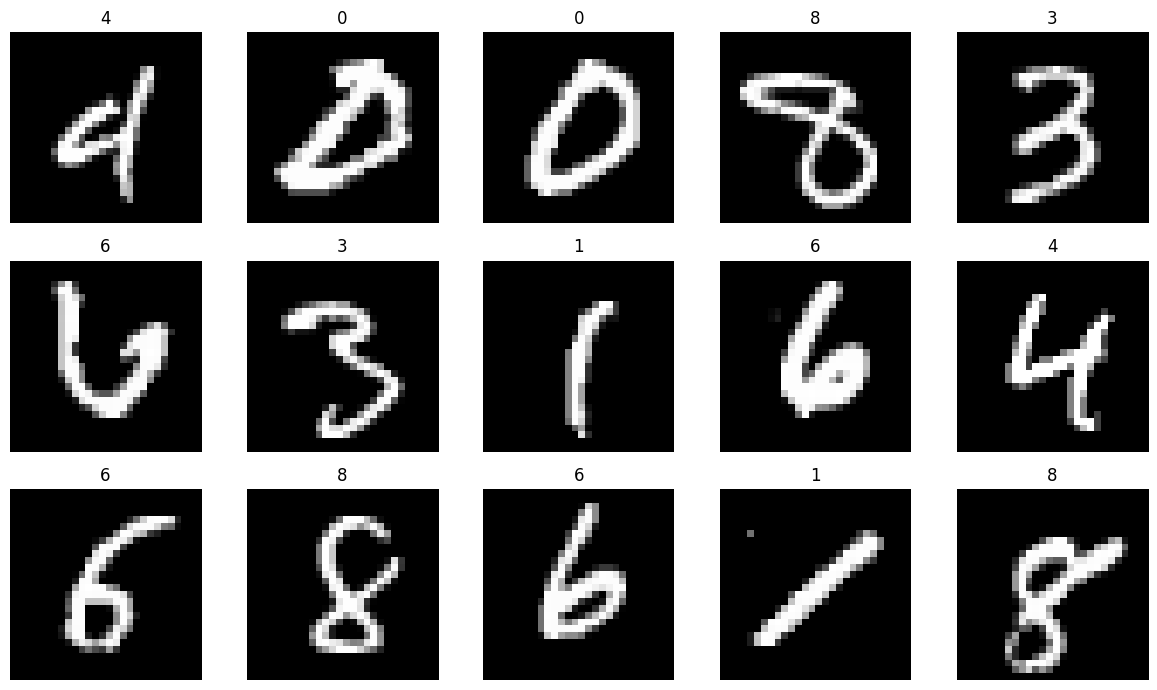

In [13]:
# show 15 random sample digits
fig, axes = plt.subplots(3, 5, figsize=(12, 7))
for ax in axes.flat:
    idx = np.random.randint(0, len(train_images))
    ax.imshow(train_images[idx], cmap='gray')
    ax.set_title(f'{train_labels[idx]}')
    ax.axis('off')
plt.tight_layout()
plt.show()


In [14]:
# network functions - supports any depth e.g. LAYERS = [784, 256, 128, 10]

LAYERS = [784, 256, 128, 10]

def init_params(layers):
    p = {'n': len(layers) - 1}
    for i in range(p['n']):
        p[f'W{i+1}'] = np.random.randn(layers[i], layers[i+1]) * np.sqrt(2.0 / layers[i])
        p[f'b{i+1}'] = np.zeros((1, layers[i+1]))
    return p

def relu(Z):
    return np.maximum(0, Z)

def relu_grad(Z):
    return (Z > 0).astype(float)

def softmax(Z):
    e = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return e / np.sum(e, axis=1, keepdims=True)

def forward(X, p):
    cache = {'A0': X}
    A = X
    for i in range(1, p['n'] + 1):
        Z = A @ p[f'W{i}'] + p[f'b{i}']
        A = relu(Z) if i < p['n'] else softmax(Z)
        cache[f'Z{i}'] = Z
        cache[f'A{i}'] = A
    return A, cache

def loss(A2, Y):
    return -np.sum(Y * np.log(A2 + 1e-8)) / Y.shape[0]

def accuracy(A, Y):
    return np.mean(np.argmax(A, axis=1) == np.argmax(Y, axis=1)) * 100

def backward(cache, Y, p):
    m = Y.shape[0]
    grads = {}
    dZ = cache[f'A{p["n"]}'] - Y  # softmax + cross-entropy combined
    for i in range(p['n'], 0, -1):
        grads[f'dW{i}'] = cache[f'A{i-1}'].T @ dZ / m
        grads[f'db{i}'] = dZ.sum(axis=0, keepdims=True) / m
        if i > 1:
            dZ = (dZ @ p[f'W{i}'].T) * relu_grad(cache[f'Z{i-1}'])
    return grads

def update(p, grads, lr):
    for i in range(1, p['n'] + 1):
        p[f'W{i}'] -= lr * grads[f'dW{i}']
        p[f'b{i}'] -= lr * grads[f'db{i}']
    return p


In [15]:
# train with train/val split, save best checkpoint

X_train_s, Y_train_s = X_train[:50000], Y_train[:50000]
X_val,     Y_val     = X_train[50000:], Y_train[50000:]

EPOCHS     = 100
BATCH_SIZE = 128
LR         = 0.1

params   = init_params(LAYERS)
best_acc = 0
history  = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(EPOCHS):
    idx = np.random.permutation(len(X_train_s))
    X_s, Y_s = X_train_s[idx], Y_train_s[idx]

    epoch_loss, epoch_correct = 0, 0
    n_batches = len(X_s) // BATCH_SIZE

    for b in range(n_batches):
        Xb = X_s[b*BATCH_SIZE:(b+1)*BATCH_SIZE]
        Yb = Y_s[b*BATCH_SIZE:(b+1)*BATCH_SIZE]
        A, cache = forward(Xb, params)
        epoch_loss    += loss(A, Yb)
        epoch_correct += np.sum(np.argmax(A, axis=1) == np.argmax(Yb, axis=1))
        params = update(params, backward(cache, Yb, params), LR)

    train_loss = epoch_loss / n_batches
    train_acc  = epoch_correct / len(X_s) * 100
    A_val, _   = forward(X_val, params)
    val_loss   = loss(A_val, Y_val)
    val_acc    = accuracy(A_val, Y_val)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        with open('best_model.pkl', 'wb') as f:
            pickle.dump(params, f)

    print(f"epoch {epoch+1:>3}/{EPOCHS}  train={train_loss:.4f}/{train_acc:.1f}%  val={val_loss:.4f}/{val_acc:.1f}%{'  *' if val_acc == best_acc else ''}")

print(f"\nbest val acc: {best_acc:.2f}%  →  saved to best_model.pkl")


epoch   1/100  train=0.4288/87.8%  val=0.2481/92.7%  *
epoch   2/100  train=0.2051/93.9%  val=0.1617/95.6%  *
epoch   3/100  train=0.1532/95.4%  val=0.1372/96.3%  *
epoch   4/100  train=0.1235/96.2%  val=0.1196/96.6%  *
epoch   5/100  train=0.1024/96.9%  val=0.1117/96.8%  *
epoch   6/100  train=0.0873/97.3%  val=0.1058/96.9%  *
epoch   7/100  train=0.0742/97.7%  val=0.1073/97.0%  *
epoch   8/100  train=0.0646/98.0%  val=0.0952/97.3%  *
epoch   9/100  train=0.0563/98.2%  val=0.0883/97.3%  *
epoch  10/100  train=0.0496/98.5%  val=0.0970/97.4%  *
epoch  11/100  train=0.0433/98.7%  val=0.0860/97.6%  *
epoch  12/100  train=0.0378/98.8%  val=0.0835/97.6%
epoch  13/100  train=0.0342/99.0%  val=0.0889/97.4%
epoch  14/100  train=0.0297/99.1%  val=0.0842/97.5%
epoch  15/100  train=0.0265/99.2%  val=0.0798/97.8%  *
epoch  16/100  train=0.0237/99.3%  val=0.0806/97.7%
epoch  17/100  train=0.0207/99.4%  val=0.0868/97.7%
epoch  18/100  train=0.0185/99.5%  val=0.0775/97.9%  *
epoch  19/100  train=0.01

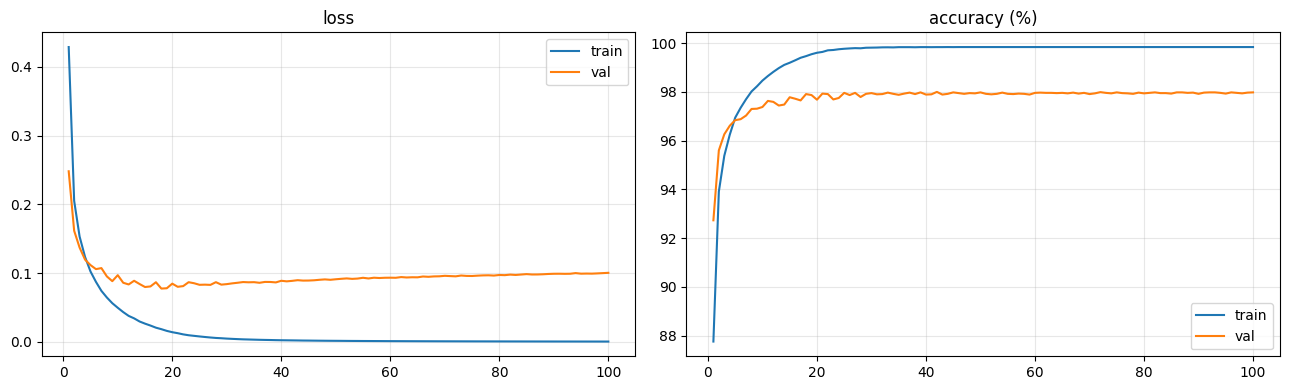

In [16]:
# training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))
e = range(1, EPOCHS + 1)
ax1.plot(e, history['train_loss'], label='train')
ax1.plot(e, history['val_loss'],   label='val')
ax1.set_title('loss'); ax1.legend(); ax1.grid(alpha=0.3)
ax2.plot(e, history['train_acc'], label='train')
ax2.plot(e, history['val_acc'],   label='val')
ax2.set_title('accuracy (%)'); ax2.legend(); ax2.grid(alpha=0.3)
plt.tight_layout(); plt.show()


test loss:     0.0737
test accuracy: 97.98%


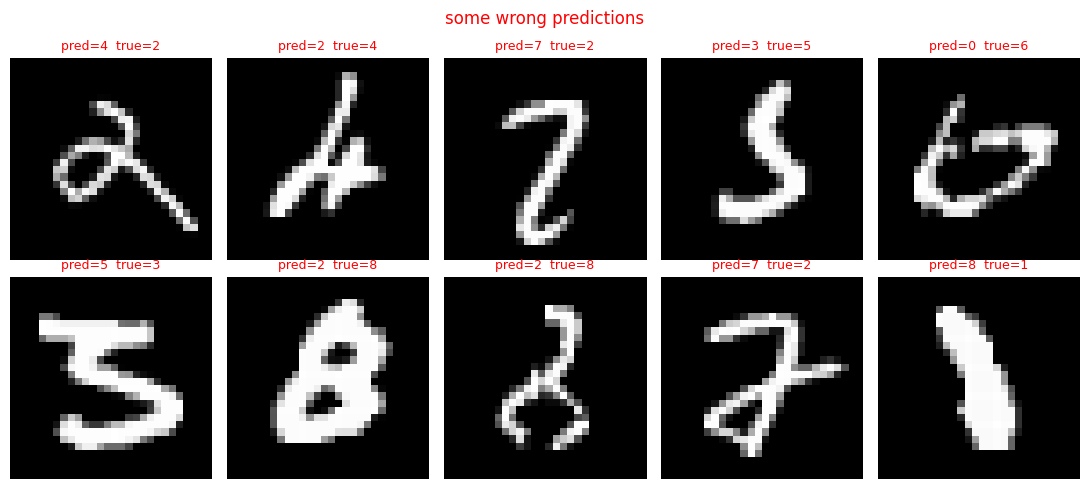

In [17]:
# test result
import pickle
with open('best_model.pkl', 'rb') as f:
    best_params = pickle.load(f)

A2_test, _ = forward(X_test, best_params)
print(f"test loss:     {loss(A2_test, Y_test):.4f}")
print(f"test accuracy: {accuracy(A2_test, Y_test):.2f}%")

pred  = np.argmax(A2_test, axis=1)
true  = np.argmax(Y_test,  axis=1)
wrong = np.where(pred != true)[0]

fig, axes = plt.subplots(2, 5, figsize=(11, 5))
fig.suptitle('some wrong predictions', color='red')
for ax, idx in zip(axes.flat, wrong[:10]):
    ax.imshow(test_images[idx], cmap='gray')
    ax.set_title(f'pred={pred[idx]}  true={true[idx]}', color='red', fontsize=9)
    ax.axis('off')
plt.tight_layout(); plt.show()


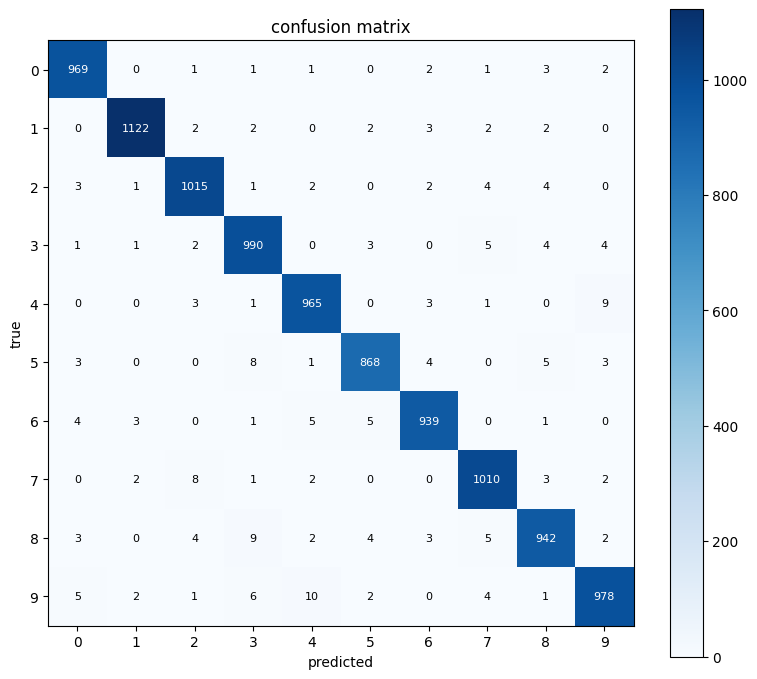

In [18]:
# confusion matrix
cm = np.zeros((10, 10), dtype=int)
for t, p in zip(true, pred):
    cm[t][p] += 1

fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(cm, cmap='Blues')
ax.set_xticks(range(10)); ax.set_yticks(range(10))
ax.set_xlabel('predicted'); ax.set_ylabel('true')
ax.set_title('confusion matrix')
for i in range(10):
    for j in range(10):
        ax.text(j, i, cm[i, j], ha='center', va='center',
                color='white' if cm[i, j] > cm.max() / 2 else 'black', fontsize=8)
plt.colorbar(im); plt.tight_layout(); plt.show()


In [19]:
# gradio live test
import gradio as gr
import pickle

# load best checkpoint if available, otherwise use last trained params
try:
    with open('best_model.pkl', 'rb') as f:
        _model = pickle.load(f)
except FileNotFoundError:
    _model = params

def predict_drawn(img):
    if img is None:
        return "draw a digit", None

    if isinstance(img, dict):
        for key in ('composite', 'background'):
            val = img.get(key)
            if val is not None and isinstance(val, np.ndarray):
                img = val
                break
        else:
            layers = img.get('layers', [])
            if layers and layers[0] is not None:
                img = layers[0]
            else:
                return "draw a digit", None

    if not isinstance(img, np.ndarray):
        return "draw a digit", None

    if img.ndim == 3:
        img = np.dot(img[..., :3], [0.299, 0.587, 0.114])

    from PIL import Image as PILImage
    resized   = np.array(PILImage.fromarray(img.astype('uint8')).resize((28, 28), PILImage.Resampling.LANCZOS))
    processed = (255 - resized).astype(np.float32) / 255.0

    if processed.max() < 0.01:
        return "draw a digit", None

    probs, _ = forward(processed.reshape(1, 784), _model)
    probs = probs[0]
    digit = int(np.argmax(probs))
    conf  = probs[digit]

    fig, ax = plt.subplots(figsize=(7, 3))
    colors = ['#e74c3c' if i == digit else '#3498db' for i in range(10)]
    ax.bar(range(10), probs, color=colors)
    ax.set_xticks(range(10))
    ax.set_ylim(0, 1)
    ax.set_xlabel('digit'); ax.set_ylabel('prob')
    ax.set_title(f'predicted: {digit}  ({conf*100:.1f}%)')
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()

    return f"## {digit}\n{conf*100:.1f}% confidence", fig

with gr.Blocks(title="digit recognition") as demo:
    gr.Markdown("## draw a digit (0–9)")
    with gr.Row():
        with gr.Column():
            canvas = gr.Sketchpad(
                type="numpy",
                canvas_size=(400, 400),
                brush=gr.Brush(default_size=20, colors=["#000000"], default_color="#000000"),
                height=400, width=400,
                label="draw here"
            )
            with gr.Row():
                btn_clear   = gr.Button("clear")
                btn_predict = gr.Button("predict", variant="primary")
        with gr.Column():
            result = gr.Markdown()
            plot   = gr.Plot()

    btn_predict.click(predict_drawn, inputs=canvas, outputs=[result, plot])
    btn_clear.click(lambda: (None, "", None), outputs=[canvas, result, plot])

demo.launch(inbrowser=True, server_name="127.0.0.1")


* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


gio: http://127.0.0.1:7862/: Operation not supported
